---
title: Calculating climate normals of temperature and precipitation
short_title: Climate normals
---

This notebook shows how to calculate monthly climate normals for temperature and precipitation for districts in Sierra Leone based on data from [ERA5-Land](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means). Climate normals ([see definition](../glossary.md)) are used as a baseline to evaluate year-to-year variability for weather and climate. 

We will use [earthkit](https://ecmwf.github.io/earthkit-website/), [xarray](https://xarray.dev/), and [pandas](https://pandas.pydata.org/) to perform the analysis. 

In [1]:
import geopandas as gpd
import xarray as xr
from earthkit import transforms

## Loading climate data

In this notebook we will use climate data for Sierra Leone downloaded from the "[ERA5-Land monthly averaged data from 1950 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means)" dataset. See [this tutorial](../getting-data/climate-data-store.ipynb) for how to download data from the Climate Data Store.

Use `xarray` to load the NetCDF file containing monthly temperature and precipitation values since 1990: 

In [2]:
file = "../data/era5-land-monthly-temp-precip-1990-2025-sierra-leone.nc"
dataset = xr.open_dataset(file)

Let's inspect the contents of the file:

In [3]:
dataset

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 428, latitude: 33, longitude: 33)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1990-01-01 ... 2025-08-01
  * latitude    (latitude) float64 264B 10.1 10.0 9.9 9.8 ... 7.2 7.1 7.0 6.9
  * longitude   (longitude) float64 264B -13.4 -13.3 -13.2 ... -10.4 -10.3 -10.2
    expver      (valid_time) <U4 7kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2MB ...
    tp          (valid_time, latitude, longitude) float32 2MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-29T21:53 GRIB to CDM+CF via cfgrib-0.9.1...

We see that the dataset contains two data variables: 
- `t2m`: Temperature 2m above surface
- `tp`: Total precipitation

The spatial resoulution for this gridded dataset is approximately 9x9 km, and the temporal resolution is monthly values.

We can drop the variables that we don't need in our analysis. We will keep time (`valid_time`) and space (`latitude` and `longitude`) dimensions.  

In [4]:
dataset_clean = dataset.drop_vars(['number', 'expver'])

## Calculate gridded climate normals

To calculate [climate normals](../glossary.md) we need to select the 30 years reference period (1991-2020). We can do this by passing a `slice(start, end)` object to the `xarray.sel()` selector:

In [ ]:
start = '1991-01'
end = '2020-12'
dataset_period = dataset_clean.sel(valid_time=slice(start, end))

This will give us 30 years of montly data. We can check that the `valid_time` dimension has 360 items (30 years x 12 months). 

In [6]:
dataset_period.dims

FrozenMappingWarningOnValuesAccess({'valid_time': 360, 'latitude': 33, 'longitude': 33})

### Temperature normals

Before we can compute the temperature normal, we extract the temperature variable from the dataset (`t2m`), and make sure to subtract `273.15` to convert from kelvin to Celcius. 

In [67]:
temp = dataset_period['t2m'] - 273.15
temp.attrs['units'] = '°C'  # update metadata to reflect degrees Celsius

To calculate the climate normal, we group the data by calendar month (all Januaries, all Februaries, etc) and compute the 30-year mean for each of the 12 months. 

In [64]:
temp_month = temp.groupby('valid_time.month').mean()

For example, here’s what the August temperature normal looks like on a map.

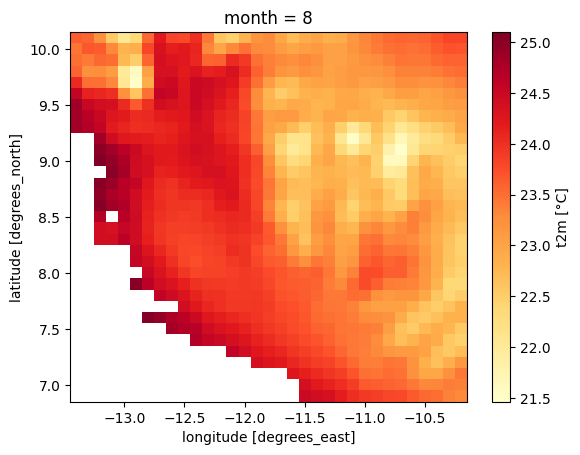

In [65]:
temp_month.sel(month=8).plot(cmap='YlOrRd')

### Precipitation

For precipitation normals, we need to make sure these are expressed in millimeters rather than meters and monthly totals rather than daily averages. We multiply each value by 1000 to go from meters to millimeters, and the number of days per month to get the total precipitation for each month.

In [68]:
precip_total = dataset_period['tp'] * 1000 * dataset_period.valid_time.dt.days_in_month
precip_total.name = 'tp'  # restore the variable name lost after multiplication
precip_total.attrs['units'] = 'mm'  # update metadata to reflect mm

We can now calculate the 30-year mean precipitation for each of the 12 calendar months.

In [63]:
precip_month = precip_total.groupby('valid_time.month').mean()

For example, here’s what the August precipitation normal looks like on a map.

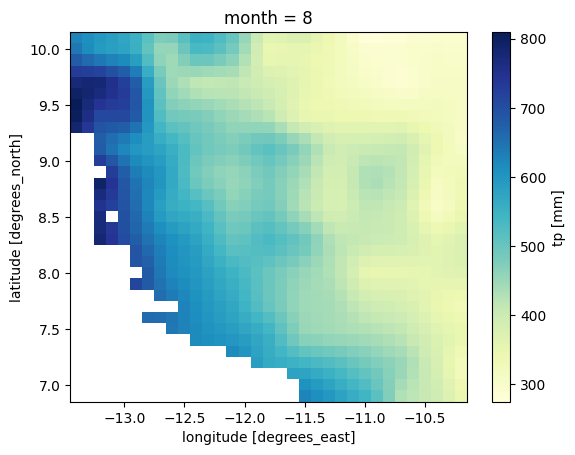

In [54]:
precip_month.sel(month=8).plot(cmap='YlGnBu')

## Climate normals for districts

The last step is to calculate the climate normals for each district in Sierra Leone. First we need to load the districts from a GeoJSON file [downloaded from DHIS2 Maps](../org-units/download-maps-app.md). 

In [55]:
district_file = "../data/sierra-leone-districts.geojson"
org_units = gpd.read_file(district_file)

### Temperature

To aggregate the temperature data to the org unit features we use the `spatial.reduce` function of [earthkit-transforms](https://earthkit-transforms.readthedocs.io), to get the spatial average of temperature normals in each org unit. See [this notebook](../aggregation/org-unit-aggregation.ipynb) for more information. 

In [56]:
temp_agg = transforms.spatial.reduce(temp_month, org_units, mask_dim="id", how='mean')

Let's look at the normal temperature for the district of `Bo` to illustrate how it changes over the 12 calendar months.

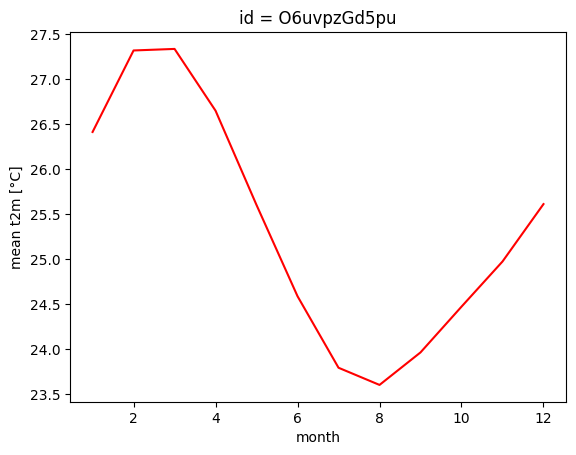

In [69]:
temp_agg.sel(id='O6uvpzGd5pu').plot(color='red')

We can also convert our xarray to a Pandas DataFrame and merge it with the `org_units` GeoPandas DataFrame to plot the district temperature normals on a map. Here we focus on the month of August to compare with the previous map of gridded temperature normals for the same month.

<Axes: >

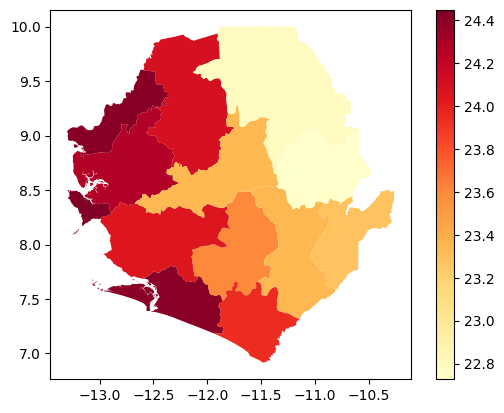

In [ ]:
month = 8
temp_df = temp_agg.to_dataframe().reset_index()
temp_aug = temp_df[temp_df['month']==month]
org_units_with_temp = org_units.merge(temp_aug, on='id', how='left')
org_units_with_temp.plot(column="t2m", cmap="YlOrRd", legend=True)

### Precipitation

We can do the same to calculate the spatial average of the normal monthly precipitation (mm) for each district:

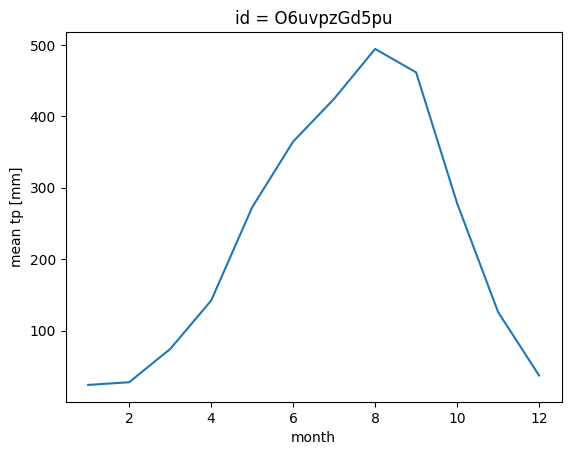

In [75]:
precip_agg = transforms.spatial.reduce(precip_month, org_units, mask_dim="id", how='mean')
precip_agg.sel(id='O6uvpzGd5pu').plot()

We can similarly convert our xarray to a merged GeoPandas DataFrame to map district precipitation normals for August:

<Axes: >

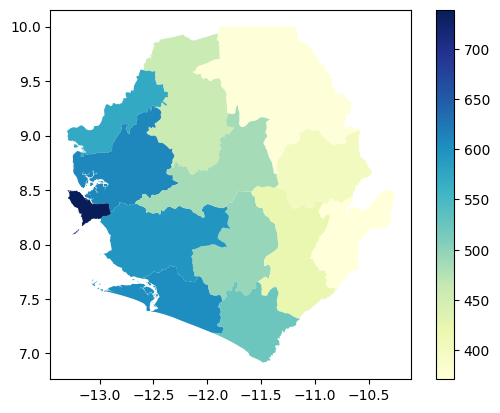

In [ ]:
month = 8
precip_df = precip_agg.to_dataframe().reset_index()
precip_aug = precip_df[precip_df['month']==month]
org_units_with_precip = org_units.merge(precip_aug, on='id', how='left')
org_units_with_precip.plot(column="tp", cmap="YlGnBu", legend=True)

If you have access to the [DHIS2 Climate app](https://dhis2.org/climate/climate-data-app/) you can check if the climate normals calculated are similar to the values calculated using Google Earth Engine.

See [more examples from Copernicus Climate Change Service (C3S)](https://ecmwf-projects.github.io/copernicus-training-c3s/reanalysis-climatology.html) of how to calculate climate normals. 